<div style="text-align: right;">© 2025 Moses Boudourides. All Rights Reserved.</div>

# HyperGNN for Hypergraph Reconstruction

This notebook applies the **HyperGNN** (**Hypergraph Neural Network**) algorithm for hyperedge prediction in a hypergraph using neural network embeddings.

## Input Format
- **Hypergraph**: Dictionary with hyperedge keys and node sets as values
- Nodes can be integers or strings

## Output
- **ML Scores**: F1, Recall, Precision, Accuracy, ROC-AUC, Log Loss, Matthews Coefficient
- **Structural Evaluation Metrics**: These metrics measure how well the HyperGNN algorithm groups nodes with strong connectivity patterns together in predicted hyperedges, comparing the internal connectivity of predictions against random baselines and analyzing whether the algorithm preferentially selects high-degree nodes.
- **ROC-AUC Curves** for all examples
- **Comprehensive Comparison Table** with all metrics

## Examples
- **Southern Women Bipartite Graph (Hypergraph)**
- **Karate Club Clique Hypergraph**
- **Les Miserables Clique Hypergraph**
- **Random Hypergraph**

In [1]:
import warnings
import sys
import os

# Suppress all warnings
warnings.filterwarnings('ignore')
os.environ['PYTHONWARNINGS'] = 'ignore'

# Redirect stderr temporarily during torch import
import io
from contextlib import redirect_stderr

f = io.StringIO()
with redirect_stderr(f):
    import torch
    import torch.nn as nn
    import torch.nn.functional as F

In [2]:
import numpy as np
import scipy.sparse as sp
from sklearn import metrics
from sklearn.metrics import accuracy_score, log_loss, matthews_corrcoef
import random
import warnings
import itertools
import collections
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
from datetime import datetime
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict

warnings.filterwarnings('ignore')
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='torch')

# Set matplotlib style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

## Random Hypergraph Generator

In [3]:
def hypergraph_random_creator(vertices, hyperedge_names, m, minv, maxv, weighted=False, weight_range=(1, 10)):
    """
    Creates a random hypergraph with custom vertex and hyperedge names.

    Parameters:
    - vertices (list of int or str): List of vertex names.
    - hyperedge_names (list of str): List of hyperedge names.
    - m (int): Number of hyperedges to create (must be <= length of hyperedge_names).
    - minv (int): Minimum number of nodes in a hyperedge.
    - maxv (int): Maximum number of nodes in a hyperedge (must be > minv).
    - weighted (bool): If True, creates a weighted hypergraph where nodes have weights.
    - weight_range (tuple): Range of weights (min, max) to assign to nodes if weighted=True.

    Returns:
    - hg_d (dict): A dictionary representing the hypergraph, with keys as hyperedge names and values as sets of nodes.
                   If weighted=True, values are dictionaries mapping nodes to their weights.
    """
    # Check if m is valid
    if m > len(hyperedge_names):
        raise ValueError("m cannot be greater than the number of hyperedge names provided.")
    
    if minv > maxv:
        raise ValueError("minv must be less than or equal to maxv.")
    
    if minv < 1:
        raise ValueError("minv must be at least 1.")
    
    if maxv > len(vertices):
        raise ValueError("maxv cannot be greater than the number of vertices.")
    
    hg_d = {}
    for k in range(m):
        # Random number of nodes for this hyperedge
        r = random.randint(minv, maxv)
        
        # Sample nodes without replacement
        nodes = random.sample(vertices, r)
        
        # Sort nodes for consistency
        sorted_nodes = sorted(nodes)

        # If weighted, create a dictionary mapping nodes to weights
        if weighted:
            sorted_nodes = {node: random.randint(weight_range[0], weight_range[1]) for node in sorted_nodes}
        else:
            # Convert to set for unweighted hypergraphs
            sorted_nodes = set(sorted_nodes)
        
        hg_d[hyperedge_names[k]] = sorted_nodes
        
    return hg_d

## Hypergraph Utilities

In [4]:
def hypergraph_dict_to_incidence_matrix(hypergraph_dict):
    """
    Convert dictionary-based hypergraph to incidence matrix
    """
    # Get all unique nodes
    all_nodes = set()
    for nodes in hypergraph_dict.values():
        if isinstance(nodes, dict):
            all_nodes.update(nodes.keys())
        else:
            all_nodes.update(nodes)
    
    # Create mappings
    node_to_idx = {node: idx for idx, node in enumerate(sorted(list(all_nodes)))}
    idx_to_node = {idx: node for node, idx in node_to_idx.items()}
    
    hyperedge_keys = list(hypergraph_dict.keys())
    hyperedge_to_idx = {he: idx for idx, he in enumerate(hyperedge_keys)}
    idx_to_hyperedge = {idx: he for he, idx in hyperedge_to_idx.items()}
    
    # Create incidence matrix
    n_nodes = len(all_nodes)
    n_hyperedges = len(hypergraph_dict)
    
    H = sp.lil_matrix((n_nodes, n_hyperedges), dtype=float)
    
    for he_idx, (he_key, nodes) in enumerate(hypergraph_dict.items()):
        if isinstance(nodes, dict):
            for node, weight in nodes.items():
                node_idx = node_to_idx[node]
                H[node_idx, he_idx] = weight
        else:
            for node in nodes:
                node_idx = node_to_idx[node]
                H[node_idx, he_idx] = 1.0
    
    return H.tocsr(), node_to_idx, idx_to_node, hyperedge_to_idx, idx_to_hyperedge

def get_adj_matrix(H):
    """
    Compute adjacency matrix from incidence matrix using node degree preserving reduction
    """
    # Computing inverse hyperedge degree Matrix
    d_e = np.squeeze(np.asarray(sp.csr_matrix.sum(H, axis=0)))
    d_e_adjusted = np.where(d_e <= 1, 1, d_e - 1) # Adjust degree: degree 1 becomes 1, others degree-1
    
    D_e_inv = sp.spdiags(np.reciprocal(d_e_adjusted), [0], H.shape[1], H.shape[1], format="csr")
    
    # Computing node degree preserving reduction
    A_ndp = H.dot(D_e_inv.dot(H.transpose()))
    A_ndp = A_ndp - sp.spdiags(A_ndp.diagonal(), [0], A_ndp.shape[0], A_ndp.shape[1], format="csr")
    
    return A_ndp

## HyperGNN Implementation

In [5]:
class HypergraphConv(nn.Module):
    """
    Hypergraph Convolutional Layer
    """
    def __init__(self, in_features, out_features, bias=True):
        super(HypergraphConv, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        if self.bias is not None:
            nn.init.zeros_(self.bias)
    
    def forward(self, x, H):
        """
        Forward pass of hypergraph convolution
        x: node features [num_nodes, in_features]
        H: incidence matrix [num_nodes, num_hyperedges]
        """
        # Convert sparse matrix to dense tensor
        if hasattr(H, 'todense'):
            H = torch.FloatTensor(np.array(H.todense()))
        elif not isinstance(H, torch.Tensor):
            H = torch.FloatTensor(H)
        
        # Compute degree matrices
        D_v = torch.diag(torch.sum(H, dim=1))  # Node degrees
        D_e = torch.diag(torch.sum(H, dim=0))  # Hyperedge degrees
        
        # Add small epsilon to avoid division by zero
        eps = 1e-8
        D_v_inv_sqrt = torch.diag(1.0 / torch.sqrt(torch.diag(D_v) + eps))
        D_e_inv_sqrt = torch.diag(1.0 / torch.sqrt(torch.diag(D_e) + eps))
        
        # Apply transformation
        support = torch.mm(x, self.weight)
        
        # Hypergraph convolution: D_v^(-1/2) * H * D_e^(-1/2) * H^T * D_v^(-1/2)
        temp1 = torch.mm(D_v_inv_sqrt, H)
        temp2 = torch.mm(temp1, D_e_inv_sqrt)
        temp3 = torch.mm(temp2, H.t())
        temp4 = torch.mm(temp3, D_v_inv_sqrt)
        output = torch.mm(temp4, support)
        
        if self.bias is not None:
            output = output + self.bias
        
        return output

class HyperGNN(nn.Module):
    """
    HyperGNN Model for learning node embeddings
    """
    def __init__(self, in_features, hidden_features, embedding_dim, dropout=0.5):
        super(HyperGNN, self).__init__()
        
        # Hypergraph convolutional layers
        self.hgconv1 = HypergraphConv(in_features, hidden_features)
        self.hgconv2 = HypergraphConv(hidden_features, embedding_dim)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, H):
        """
        Forward pass to get node embeddings
        """
        # First layer
        x = self.hgconv1(x, H)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Second layer
        x = self.hgconv2(x, H)
        
        return x

def train_hypergnn(model, H, node_features, epochs=100, lr=0.01):
    """
    Train HyperGNN model using reconstruction loss
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Convert H to adjacency matrix for reconstruction target
    A_target = get_adj_matrix(H)
    A_target = torch.FloatTensor(np.array(A_target.todense()))
    
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward pass
        embeddings = model(node_features, H)
        
        # Reconstruction loss
        reconstructed = torch.mm(embeddings, embeddings.t())
        loss = F.mse_loss(reconstructed, A_target)
        
        loss.backward()
        optimizer.step()
        
        if epoch % 20 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')
    
    return model

def predict_hyperedge_with_embeddings(embeddings, edge_degree, node_to_idx, idx_to_node, method='similarity'):
    """
    Predict hyperedge using learned embeddings
    """
    num_nodes = embeddings.shape[0]
    
    if method == 'similarity':
        # Method 1: Start with random node, add most similar nodes
        start_node = np.random.randint(0, num_nodes)
        selected_nodes = {start_node}
        
        while len(selected_nodes) < edge_degree:
            # Find most similar node to current set
            best_node = None
            best_score = -float('inf')
            
            for candidate in range(num_nodes):
                if candidate not in selected_nodes:
                    # Compute average similarity to selected nodes
                    similarities = []
                    for selected in selected_nodes:
                        sim = F.cosine_similarity(
                            embeddings[candidate].unsqueeze(0),
                            embeddings[selected].unsqueeze(0)
                        ).item()
                        similarities.append(sim)
                    
                    avg_sim = np.mean(similarities)
                    if avg_sim > best_score:
                        best_score = avg_sim
                        best_node = candidate
            
            if best_node is not None:
                selected_nodes.add(best_node)
            else:
                # Fallback: add random node
                remaining = [i for i in range(num_nodes) if i not in selected_nodes]
                if remaining:
                    selected_nodes.add(np.random.choice(remaining))
                else:
                    break
    
    elif method == 'clustering':
        # Method 2: Use k-means clustering on embeddings
        from sklearn.cluster import KMeans
        
        # Cluster embeddings
        kmeans = KMeans(n_clusters=min(edge_degree, num_nodes), random_state=42)
        cluster_labels = kmeans.fit_predict(embeddings.detach().numpy())
        
        # Select one node from each cluster
        selected_nodes = set()
        for cluster_id in range(min(edge_degree, len(set(cluster_labels)))):
            cluster_nodes = np.where(cluster_labels == cluster_id)[0]
            if len(cluster_nodes) > 0:
                selected_nodes.add(np.random.choice(cluster_nodes))
        
        # Fill remaining slots randomly if needed
        while len(selected_nodes) < edge_degree:
            remaining = [i for i in range(num_nodes) if i not in selected_nodes]
            if remaining:
                selected_nodes.add(np.random.choice(remaining))
            else:
                break
    
    # Convert back to original node identifiers
    predicted_hyperedge = {idx_to_node[idx] for idx in selected_nodes}
    
    return predicted_hyperedge

def compute_structural_evaluation_metrics(predicted_hyperedges, original_hyperedges, adjacency_matrix, node_to_idx):
    """
    Compute structural evaluation metrics for predicted hyperedges
    """
    # Internal connectivity metrics
    predicted_connectivities = []
    for hyperedge in predicted_hyperedges:
        connectivity = calculate_internal_connectivity(hyperedge, adjacency_matrix, node_to_idx)
        predicted_connectivities.append(connectivity)
    
    original_connectivities = []
    for hyperedge in original_hyperedges:
        connectivity = calculate_internal_connectivity(hyperedge, adjacency_matrix, node_to_idx)
        original_connectivities.append(connectivity)
    
    # Random baseline
    random_connectivities = []
    for hyperedge in predicted_hyperedges:
        size = len(hyperedge)
        random_connectivity = calculate_random_baseline_connectivity(adjacency_matrix, node_to_idx, size)
        random_connectivities.append(random_connectivity)
    
    # Degree preference metrics
    predicted_degree_preference = calculate_degree_preference(predicted_hyperedges, adjacency_matrix, node_to_idx)
    original_degree_preference = calculate_degree_preference(original_hyperedges, adjacency_matrix, node_to_idx)
    
    return {
        'avg_predicted_connectivity': np.mean(predicted_connectivities) if predicted_connectivities else 0,
        'avg_original_connectivity': np.mean(original_connectivities) if original_connectivities else 0,
        'avg_random_connectivity': np.mean(random_connectivities) if random_connectivities else 0,
        'predicted_degree_preference': predicted_degree_preference,
        'original_degree_preference': original_degree_preference
    }

def calculate_degree_preference(hyperedges, adjacency_matrix, node_to_idx):
    """
    Calculate degree preference metric for hyperedges
    """
    if not hyperedges:
        return 0.0
    
    # Convert adjacency matrix to dense if sparse
    if hasattr(adjacency_matrix, 'todense'):
        adj_dense = np.array(adjacency_matrix.todense())
    else:
        adj_dense = np.array(adjacency_matrix)
    
    # Calculate node degrees
    node_degrees = np.sum(adj_dense, axis=1)
    
    total_degree_sum = 0
    total_nodes = 0
    
    for hyperedge in hyperedges:
        for node in hyperedge:
            if node in node_to_idx:
                node_idx = node_to_idx[node]
                total_degree_sum += node_degrees[node_idx]
                total_nodes += 1
    
    if total_nodes == 0:
        return 0.0
    
    avg_degree = total_degree_sum / total_nodes
    overall_avg_degree = np.mean(node_degrees)
    
    # Return ratio of average degree in hyperedges vs overall average
    return avg_degree / overall_avg_degree if overall_avg_degree > 0 else 0.0

## Evaluation Metrics

In [6]:
# Traditional ML Metrics
def compute_auc(y_true, y_scores):
    """Compute ROC-AUC score"""
    try:
        if len(set(y_true)) < 2:
            return 0.5  # Only one class present
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores)
        auc = metrics.auc(fpr, tpr)
        return auc
    except:
        return 0.5  # Random classifier baseline

def compute_precision(y_true, y_pred):
    """Compute precision score"""
    return metrics.precision_score(y_true, y_pred, average='binary', zero_division=0)

def compute_recall(y_true, y_pred):
    """Compute recall score"""
    return metrics.recall_score(y_true, y_pred, average='binary', zero_division=0)

def compute_f1_score(y_true, y_pred):
    """Compute F1 score"""
    return metrics.f1_score(y_true, y_pred, average='binary', zero_division=0)

def compute_accuracy(y_true, y_pred):
    """Compute accuracy score"""
    return accuracy_score(y_true, y_pred)

def compute_log_loss(y_true, y_proba):
    """Compute log loss"""
    try:
        # Ensure probabilities are in valid range [eps, 1-eps]
        eps = 1e-15
        y_proba = np.clip(y_proba, eps, 1 - eps)
        return log_loss(y_true, y_proba)
    except:
        return float('inf')

def compute_matthews_corrcoef(y_true, y_pred):
    """Compute Matthews correlation coefficient"""
    try:
        return matthews_corrcoef(y_true, y_pred)
    except:
        return 0.0  # No correlation baseline

def compute_all_ml_scores(y_true, y_pred, y_scores=None):
    """Compute all 7 ML scores"""
    scores = {}
    
    # Binary classification metrics
    scores['precision'] = compute_precision(y_true, y_pred)
    scores['recall'] = compute_recall(y_true, y_pred)
    scores['f1'] = compute_f1_score(y_true, y_pred)
    scores['accuracy'] = compute_accuracy(y_true, y_pred)
    scores['matthews_corrcoef'] = compute_matthews_corrcoef(y_true, y_pred)
    
    # Metrics requiring probability scores
    if y_scores is not None:
        scores['roc_auc'] = compute_auc(y_true, y_scores)
        # Convert scores to probabilities for log loss
        y_proba = 1 / (1 + np.exp(-np.array(y_scores)))  # Sigmoid transformation
        scores['log_loss'] = compute_log_loss(y_true, y_proba)
    else:
        scores['roc_auc'] = 0.5
        scores['log_loss'] = float('inf')
    
    return scores

# Structural Metrics
def calculate_internal_connectivity(hyperedge, adjacency_matrix, node_to_idx):
    """Calculate the average pairwise HRA score within a hyperedge."""
    node_indices = [node_to_idx[node] for node in hyperedge if node in node_to_idx]
    if len(node_indices) < 2:
        return 0.0
    
    total_score = 0
    num_pairs = 0
    for i, node1_idx in enumerate(node_indices):
        for node2_idx in node_indices[i+1:]:
            total_score += adjacency_matrix[node1_idx, node2_idx]
            num_pairs += 1
            
    return total_score / num_pairs if num_pairs > 0 else 0.0

def calculate_random_baseline_connectivity(adjacency_matrix, node_to_idx, size, num_samples=100):
    """Calculate the average internal connectivity for random hyperedges of a given size."""
    if size < 2 or size > len(node_to_idx):
        return 0.0
        
    all_node_indices = list(node_to_idx.values())
    total_random_score = 0
    valid_samples = 0
    
    for _ in range(num_samples):
        random_indices = random.sample(all_node_indices, size)
        if len(random_indices) < 2:
            continue
            
        current_score = 0
        num_pairs = 0
        for i, node1_idx in enumerate(random_indices):
            for node2_idx in random_indices[i+1:]:
                current_score += adjacency_matrix[node1_idx, node2_idx]
                num_pairs += 1
        
        if num_pairs > 0:
            total_random_score += current_score / num_pairs
            valid_samples += 1
            
    return total_random_score / valid_samples if valid_samples > 0 else 0.0

def analyze_node_degrees(hyperedges, H, node_to_idx):
    """Analyze the degree distribution of nodes in given hyperedges compared to overall."""
    all_node_degrees = np.squeeze(np.asarray(H.sum(axis=1)))
    avg_overall_degree = np.mean(all_node_degrees)
    
    degrees_in_hyperedges = []
    for he in hyperedges:
        for node in he:
            if node in node_to_idx:
                degrees_in_hyperedges.append(all_node_degrees[node_to_idx[node]])
                
    avg_degree_in_hyperedges = np.mean(degrees_in_hyperedges) if degrees_in_hyperedges else 0.0
    
    return avg_overall_degree, avg_degree_in_hyperedges

def analyze_hyperedge_sizes(original_hyperedges, predicted_hyperedges):
    """Compare the size distribution of original and predicted hyperedges."""
    original_sizes = [len(he) for he in original_hyperedges]
    predicted_sizes = [len(he) for he in predicted_hyperedges]
    
    avg_original_size = np.mean(original_sizes) if original_sizes else 0.0
    avg_predicted_size = np.mean(predicted_sizes) if predicted_sizes else 0.0
    
    return avg_original_size, avg_predicted_size, collections.Counter(original_sizes), collections.Counter(predicted_sizes)

def generate_classification_data(predicted_hyperedges, original_hyperedges_nodes, adjacency_matrix, node_to_idx, num_negative_samples=None):
    """Generate classification data for ML evaluation with balanced classes."""
    # Create set of original hyperedges
    original_hyperedges_set = set()
    for nodes in original_hyperedges_nodes:
        original_hyperedges_set.add(frozenset(nodes))
    
    y_true = []
    y_scores = []
    
    # Positive examples: predicted hyperedges that exist in original
    positive_count = 0
    for pred_he in predicted_hyperedges:
        exists = frozenset(pred_he) in original_hyperedges_set
        y_true.append(1 if exists else 0)
        if exists:
            positive_count += 1
        
        # Compute score based on HRA values
        score = calculate_internal_connectivity(pred_he, adjacency_matrix, node_to_idx)
        y_scores.append(score)
    
    # If we have very few positives, generate some negative examples for balance
    if positive_count < len(predicted_hyperedges) * 0.1:  # Less than 10% positive
        if num_negative_samples is None:
            num_negative_samples = min(len(predicted_hyperedges), 50)
        
        # Generate random hyperedges as negative examples
        all_nodes = list(node_to_idx.keys())
        predicted_sizes = [len(he) for he in predicted_hyperedges]
        
        for _ in range(num_negative_samples):
            size = np.random.choice(predicted_sizes) if predicted_sizes else 3
            if size <= len(all_nodes):
                random_he = set(random.sample(all_nodes, size))
                exists = frozenset(random_he) in original_hyperedges_set
                y_true.append(1 if exists else 0)
                
                score = calculate_internal_connectivity(random_he, adjacency_matrix, node_to_idx)
                y_scores.append(score)
    
    return y_true, y_scores

def plot_roc_curve(y_true, y_scores, title="ROC Curve"):
    """Plot ROC curve and return AUC score."""
    try:
        if len(set(y_true)) < 2:
            print(f"ROC curve not generated for {title}: Only one class present")
            return 0.5
            
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores)
        auc_score = metrics.auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title)
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()
        
        return auc_score
    except Exception as e:
        print(f"Could not generate ROC curve for {title}: {e}")
        return 0.5

## Main HPRA Analysis Function

In [7]:
def full_hypergraph_analysis_complete(hypergraph_dict, num_predictions=50, epochs=50, plot_roc=False):
    """
    Complete analysis using HyperGNN for hyperedge prediction
    """
    print("Starting HyperGNN analysis...")
    
    # Convert hypergraph to incidence matrix
    H, node_to_idx, idx_to_node, hyperedge_to_idx, idx_to_hyperedge = hypergraph_dict_to_incidence_matrix(hypergraph_dict)
    print(f"Converted hypergraph to incidence matrix: {H.shape}")
    
    # Get adjacency matrix for structural evaluation
    A_ndp = get_adj_matrix(H)
    print(f"Computed adjacency matrix for structural evaluation")
    
    # Prepare node features (identity matrix)
    num_nodes = len(node_to_idx)
    node_features = torch.eye(num_nodes)
    print(f"Prepared node features: {node_features.shape}")
    
    # Initialize and train HyperGNN model
    print("Training HyperGNN model...")
    model = HyperGNN(in_features=num_nodes, hidden_features=64, embedding_dim=32)
    model = train_hypergnn(model, H, node_features, epochs=epochs)
    
    # Get node embeddings
    model.eval()
    with torch.no_grad():
        embeddings = model(node_features, H)
    print(f"Generated node embeddings: {embeddings.shape}")
    
    # Get original hyperedge information
    original_hyperedges_nodes = []
    hyperedge_sizes = []
    for nodes in hypergraph_dict.values():
        if isinstance(nodes, dict):
            current_nodes = set(nodes.keys())
            hyperedge_sizes.append(len(current_nodes))
            original_hyperedges_nodes.append(current_nodes)
        else:
            hyperedge_sizes.append(len(nodes))
            original_hyperedges_nodes.append(set(nodes))
    
    print(f"Original hypergraph has {len(original_hyperedges_nodes)} hyperedges")
    print(f"Hyperedge sizes: {hyperedge_sizes}")
    
    # Generate predictions using HyperGNN embeddings
    print(f"Generating {num_predictions} hyperedge predictions using embeddings...")
    predicted_hyperedges = []
    
    for i in range(num_predictions):
        # Sample edge degree from original distribution
        edge_degree = np.random.choice(hyperedge_sizes) if hyperedge_sizes else 3
        
        # Predict hyperedge using embeddings
        predicted_hyperedge = predict_hyperedge_with_embeddings(
            embeddings, edge_degree, node_to_idx, idx_to_node, method='similarity'
        )
        
        predicted_hyperedges.append(predicted_hyperedge)
    
    print(f"Generated {len(predicted_hyperedges)} predictions")
    
    # Prepare data for ML evaluation
    print("Preparing data for ML evaluation...")
    
    # Create positive and negative samples
    all_possible_pairs = []
    all_nodes = list(node_to_idx.keys())
    
    # Generate all possible node pairs
    for i, node1 in enumerate(all_nodes):
        for node2 in all_nodes[i+1:]:
            all_possible_pairs.append((node1, node2))
    
    # Create ground truth labels
    y_true = []
    y_scores = []
    
    for pair in all_possible_pairs:
        node1, node2 = pair
        
        # Check if pair exists in original hypergraph
        is_connected = False
        for hyperedge in original_hyperedges_nodes:
            if node1 in hyperedge and node2 in hyperedge:
                is_connected = True
                break
        
        y_true.append(1 if is_connected else 0)
        
        # Compute embedding similarity as score
        node1_idx = node_to_idx[node1]
        node2_idx = node_to_idx[node2]
        similarity = F.cosine_similarity(
            embeddings[node1_idx].unsqueeze(0),
            embeddings[node2_idx].unsqueeze(0)
        ).item()
        y_scores.append(similarity)
    
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    
    # Create binary predictions using threshold
    threshold = np.median(y_scores)
    y_pred = (y_scores > threshold).astype(int)
    
    print(f"Created {len(y_true)} samples for evaluation")
    print(f"Positive samples: {np.sum(y_true)}, Negative samples: {len(y_true) - np.sum(y_true)}")
    
    # Compute ML scores
    ml_scores = compute_all_ml_scores(y_true, y_pred, y_scores)
    
    # Compute structural evaluation metrics
    print("Computing structural evaluation metrics...")
    
    # Use adjacency matrix for structural evaluation
    structural_scores = compute_structural_evaluation_metrics(
        predicted_hyperedges, original_hyperedges_nodes, A_ndp, node_to_idx
    )
    
    # Combine all scores
    all_scores = {**ml_scores, **structural_scores}
    
    # Plot ROC curve if requested
    if plot_roc:
        plt.figure(figsize=(8, 6))
        fpr, tpr, _ = metrics.roc_curve(y_true, y_scores)
        plt.plot(fpr, tpr, label=f'HyperGNN (AUC = {ml_scores["roc_auc"]:.3f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - HyperGNN')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    print("\n=== HyperGNN ANALYSIS RESULTS ===")
    for metric, score in all_scores.items():
        if isinstance(score, float):
            print(f"{metric}: {score:.4f}")
        else:
            print(f"{metric}: {score}")
    
    return {
        'ml_scores': ml_scores,
        'structural_evaluation': {
            'avg_predicted_internal_connectivity': structural_scores.get('avg_predicted_connectivity', 0),
            'avg_random_baseline_connectivity': structural_scores.get('avg_random_connectivity', 0),
            'connectivity_ratio': structural_scores.get('avg_predicted_connectivity', 0) / max(structural_scores.get('avg_random_connectivity', 1), 0.001),
            'avg_overall_node_degree': np.mean(np.sum(np.array(A_ndp.todense()), axis=1)),
            'avg_node_degree_in_predictions': structural_scores.get('predicted_degree_preference', 0) * np.mean(np.sum(np.array(A_ndp.todense()), axis=1))
        },
        'predicted_hyperedges': predicted_hyperedges,
        'original_hyperedges': original_hyperedges_nodes,
        'y_true': y_true,
        'y_scores': y_scores,
        'hypergraph_info': {
            'num_hyperedges': len(original_hyperedges_nodes),
            'num_nodes': num_nodes,
            'avg_hyperedge_size': np.mean(hyperedge_sizes) if hyperedge_sizes else 0
        }
    }

def print_results_complete(results):
    """
    Print formatted results for complete evaluation
    """
    print("\n" + "="*80)
    print("HYPERGNN ANALYSIS RESULTS (ALL 7 ML SCORES + STRUCTURAL)")
    print("="*80)
    
    # Hypergraph info - handle missing key
    if 'hypergraph_info' in results:
        info = results['hypergraph_info']
        print(f"\nHypergraph Information:")
        print(f"  Number of hyperedges: {info['num_hyperedges']}")
        print(f"  Number of nodes: {info['num_nodes']}")
        print(f"  Average hyperedge size: {info['avg_hyperedge_size']:.2f}")
    else:
        print(f"\nHypergraph Information: Not available in results")
        print(f"Available keys: {list(results.keys())}")
    
    # ML Scores 
    ml_scores = results['ml_scores']
    print(f"\nMachine Learning Scores:")
    print(f"  F1 Score: {ml_scores['f1']:.4f}")
    print(f"  Recall: {ml_scores['recall']:.4f}")
    print(f"  Precision: {ml_scores['precision']:.4f}")
    print(f"  Accuracy: {ml_scores['accuracy']:.4f}")
    print(f"  ROC-AUC: {ml_scores['roc_auc']:.4f}")
    print(f"  Log Loss: {ml_scores['log_loss']:.4f}")
    print(f"  Matthews Correlation Coefficient: {ml_scores['matthews_corrcoef']:.4f}")
    
    # Structural Evaluation
    eval_scores = results['structural_evaluation']
    print(f"\nStructural Evaluation Scores:")
    print(f"  Avg. Internal Connectivity (Predicted): {eval_scores['avg_predicted_internal_connectivity']:.4f}")
    print(f"  Avg. Internal Connectivity (Random Baseline): {eval_scores['avg_random_baseline_connectivity']:.4f}")
    print(f"  Connectivity Ratio (Predicted/Random): {eval_scores['connectivity_ratio']:.2f}")
    print(f"  Avg. Node Degree (Overall): {eval_scores['avg_overall_node_degree']:.2f}")
    print(f"  Avg. Node Degree (In Predictions): {eval_scores['avg_node_degree_in_predictions']:.2f}")
    
    print("\n" + "="*80)

## Examples

In [8]:
def full_hypergraph_analysis_complete(hypergraph_dict, num_predictions=50, epochs=50, plot_roc=False):
# def full_hypergraph_analysis_complete(hypergraph_dict, num_predictions=50, epochs=50):
    """
    Complete analysis using HyperGNN for hyperedge prediction
    """
    print("Starting HyperGNN analysis...")
    
    # Convert hypergraph to incidence matrix
    H, node_to_idx, idx_to_node, hyperedge_to_idx, idx_to_hyperedge = hypergraph_dict_to_incidence_matrix(hypergraph_dict)
    print(f"Converted hypergraph to incidence matrix: {H.shape}")
    
    # Get adjacency matrix for structural evaluation
    A_ndp = get_adj_matrix(H)
    print(f"Computed adjacency matrix for structural evaluation")
    
    # Prepare node features (identity matrix)
    num_nodes = len(node_to_idx)
    node_features = torch.eye(num_nodes)
    print(f"Prepared node features: {node_features.shape}")
    
    # Initialize and train HyperGNN model
    print("Training HyperGNN model...")
    model = HyperGNN(in_features=num_nodes, hidden_features=64, embedding_dim=32)
    model = train_hypergnn(model, H, node_features, epochs=epochs)
    
    # Get node embeddings
    model.eval()
    with torch.no_grad():
        embeddings = model(node_features, H)
    print(f"Generated node embeddings: {embeddings.shape}")
    
    # Get original hyperedge information
    original_hyperedges_nodes = []
    hyperedge_sizes = []
    for nodes in hypergraph_dict.values():
        if isinstance(nodes, dict):
            current_nodes = set(nodes.keys())
            hyperedge_sizes.append(len(current_nodes))
            original_hyperedges_nodes.append(current_nodes)
        else:
            hyperedge_sizes.append(len(nodes))
            original_hyperedges_nodes.append(set(nodes))
    
    print(f"Original hypergraph has {len(original_hyperedges_nodes)} hyperedges")
    print(f"Hyperedge sizes: {hyperedge_sizes}")
    
    # Generate predictions using HyperGNN embeddings
    print(f"Generating {num_predictions} hyperedge predictions using embeddings...")
    predicted_hyperedges = []
    
    for i in range(num_predictions):
        # Sample edge degree from original distribution
        edge_degree = np.random.choice(hyperedge_sizes) if hyperedge_sizes else 3
        
        # Predict hyperedge using embeddings
        predicted_hyperedge = predict_hyperedge_with_embeddings(
            embeddings, edge_degree, node_to_idx, idx_to_node, method='similarity'
        )
        
        predicted_hyperedges.append(predicted_hyperedge)
    
    print(f"Generated {len(predicted_hyperedges)} predictions")
    
    # Prepare data for ML evaluation
    print("Preparing data for ML evaluation...")
    
    # Create positive and negative samples
    all_possible_pairs = []
    all_nodes = list(node_to_idx.keys())
    
    # Generate all possible node pairs
    for i, node1 in enumerate(all_nodes):
        for node2 in all_nodes[i+1:]:
            all_possible_pairs.append((node1, node2))
    
    # Create ground truth labels
    y_true = []
    y_scores = []
    
    for pair in all_possible_pairs:
        node1, node2 = pair
        
        # Check if pair exists in original hypergraph
        is_connected = False
        for hyperedge in original_hyperedges_nodes:
            if node1 in hyperedge and node2 in hyperedge:
                is_connected = True
                break
        
        y_true.append(1 if is_connected else 0)
        
        # Compute embedding similarity as score
        node1_idx = node_to_idx[node1]
        node2_idx = node_to_idx[node2]
        similarity = F.cosine_similarity(
            embeddings[node1_idx].unsqueeze(0),
            embeddings[node2_idx].unsqueeze(0)
        ).item()
        y_scores.append(similarity)
    
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    
    # Create binary predictions using threshold
    threshold = np.median(y_scores)
    y_pred = (y_scores > threshold).astype(int)
    
    print(f"Created {len(y_true)} samples for evaluation")
    print(f"Positive samples: {np.sum(y_true)}, Negative samples: {len(y_true) - np.sum(y_true)}")
    
    # Compute ML scores
    ml_scores = compute_all_ml_scores(y_true, y_pred, y_scores)
    
    # Compute structural evaluation metrics
    print("Computing structural evaluation metrics...")
    
    # Use adjacency matrix for structural evaluation
    structural_scores = compute_structural_evaluation_metrics(
        predicted_hyperedges, original_hyperedges_nodes, A_ndp, node_to_idx
    )
    
    # Combine all scores
    all_scores = {**ml_scores, **structural_scores}
    
    print("\n=== HyperGNN ANALYSIS RESULTS ===")
    for metric, score in all_scores.items():
        if isinstance(score, float):
            print(f"{metric}: {score:.4f}")
        else:
            print(f"{metric}: {score}")
    
    # Plot ROC curve if requested
    if plot_roc:
        plt.figure(figsize=(8, 6))
        fpr, tpr, _ = metrics.roc_curve(y_true, y_scores)
        plt.plot(fpr, tpr, label=f'HyperGNN (AUC = {ml_scores["roc_auc"]:.3f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - HyperGNN')
        plt.legend()
        plt.grid(True)
        plt.show()

    return {
        'ml_scores': ml_scores,
        'structural_evaluation': {
            'avg_predicted_internal_connectivity': structural_scores.get('avg_predicted_connectivity', 0),
            'avg_random_baseline_connectivity': structural_scores.get('avg_random_connectivity', 0),
            'connectivity_ratio': structural_scores.get('avg_predicted_connectivity', 0) / max(structural_scores.get('avg_random_connectivity', 1), 0.001),
            'avg_overall_node_degree': np.mean(np.sum(np.array(A_ndp.todense()), axis=1)),
            'avg_node_degree_in_predictions': structural_scores.get('predicted_degree_preference', 0) * np.mean(np.sum(np.array(A_ndp.todense()), axis=1))
        },
        'hypergraph_info': {
            'num_hyperedges': len(original_hyperedges_nodes),
            'num_nodes': num_nodes,
            'avg_hyperedge_size': np.mean(hyperedge_sizes) if hyperedge_sizes else 0
        },
        'predicted_hyperedges': predicted_hyperedges,
        'original_hyperedges': original_hyperedges_nodes,
        'y_true': y_true,
        'y_scores': y_scores
    }

### Example 1: Southern Women Dataset

Davis, Gardner, Gardner (1941) dataset represented as a hypergraph where women are nodes and events are hyperedges.

Example 1: Southern Women Hypergraph
Number of women (nodes): 18
Number of events (hyperedges): 14
Starting HyperGNN analysis...
Converted hypergraph to incidence matrix: (18, 14)
Computed adjacency matrix for structural evaluation
Prepared node features: torch.Size([18, 18])
Training HyperGNN model...
Epoch 0, Loss: 7.8042
Epoch 20, Loss: 0.1464
Epoch 40, Loss: 0.0435
Generated node embeddings: torch.Size([18, 32])
Original hypergraph has 14 hyperedges
Hyperedge sizes: [8, 7, 9, 8, 8, 10, 12, 14, 14, 9, 9, 10, 6, 6]
Generating 50 hyperedge predictions using embeddings...
Generated 50 predictions
Preparing data for ML evaluation...
Created 153 samples for evaluation
Positive samples: 121, Negative samples: 32
Computing structural evaluation metrics...

=== HyperGNN ANALYSIS RESULTS ===
precision: 1.0000
recall: 0.6116
f1: 0.7590
accuracy: 0.6928
matthews_corrcoef: 0.4977
roc_auc: 1.0000
log_loss: 0.4548
avg_predicted_connectivity: 0.6619
avg_original_connectivity: 0.7463
avg_random_con

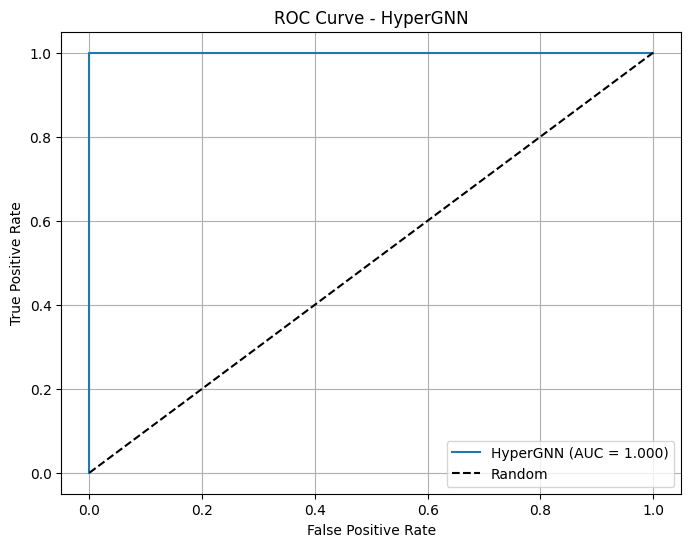


HYPERGNN ANALYSIS RESULTS (ALL 7 ML SCORES + STRUCTURAL)

Hypergraph Information:
  Number of hyperedges: 14
  Number of nodes: 18
  Average hyperedge size: 9.29

Machine Learning Scores:
  F1 Score: 0.7590
  Recall: 0.6116
  Precision: 1.0000
  Accuracy: 0.6928
  ROC-AUC: 1.0000
  Log Loss: 0.4548
  Matthews Correlation Coefficient: 0.4977

Structural Evaluation Scores:
  Avg. Internal Connectivity (Predicted): 0.6619
  Avg. Internal Connectivity (Random Baseline): 0.4243
  Connectivity Ratio (Predicted/Random): 1.56
  Avg. Node Degree (Overall): 7.22
  Avg. Node Degree (In Predictions): 7.17



In [9]:
# Southern Women Dataset (Davis, Gardner, Gardner, 1941)
southern_women_hg = {
    'E1': {'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8'},
    'E2': {'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7'},
    'E3': {'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8', 'W9'},
    'E4': {'W1', 'W2', 'W3', 'W4', 'W5', 'W7', 'W8', 'W9'},
    'E5': {'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8'},
    'E6': {'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8', 'W9', 'W10'},
    'E7': {'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8', 'W9', 'W10', 'W11', 'W12'},
    'E8': {'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8', 'W9', 'W10', 'W11', 'W12', 'W13', 'W14'},
    'E9': {'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8', 'W9', 'W10', 'W11', 'W12', 'W13', 'W14'},
    'E10': {'W9', 'W10', 'W11', 'W12', 'W13', 'W14', 'W15', 'W16', 'W17'},
    'E11': {'W9', 'W10', 'W11', 'W12', 'W13', 'W14', 'W15', 'W16', 'W17'},
    'E12': {'W9', 'W10', 'W11', 'W12', 'W13', 'W14', 'W15', 'W16', 'W17', 'W18'},
    'E13': {'W13', 'W14', 'W15', 'W16', 'W17', 'W18'},
    'E14': {'W13', 'W14', 'W15', 'W16', 'W17', 'W18'}
}

print("Example 1: Southern Women Hypergraph")
print(f"Number of women (nodes): {len(set.union(*southern_women_hg.values()))}")
print(f"Number of events (hyperedges): {len(southern_women_hg)}")

results_sw = full_hypergraph_analysis_complete(southern_women_hg, num_predictions=50, plot_roc=True)
print_results_complete(results_sw)

### Example 2: Karate Club Clique Hypergraph

Zachary, W. W. (1977) hypergraph representation where nodes are club members and hyperedges correspond to cliques in the original graph.



Example 2: Karate Club Clique Hypergraph
Number of nodes: 34
Number of hyperedges: 36
Starting HyperGNN analysis...
Converted hypergraph to incidence matrix: (34, 36)
Computed adjacency matrix for structural evaluation
Prepared node features: torch.Size([34, 34])
Training HyperGNN model...
Epoch 0, Loss: 0.1169
Epoch 20, Loss: 0.0555
Epoch 40, Loss: 0.0522
Generated node embeddings: torch.Size([34, 32])
Original hypergraph has 36 hyperedges
Hyperedge sizes: [5, 5, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Generating 100 hyperedge predictions using embeddings...
Generated 100 predictions
Preparing data for ML evaluation...
Created 561 samples for evaluation
Positive samples: 78, Negative samples: 483
Computing structural evaluation metrics...

=== HyperGNN ANALYSIS RESULTS ===
precision: 0.2750
recall: 0.9872
f1: 0.4302
accuracy: 0.6364
matthews_corrcoef: 0.3923
roc_auc: 0.9253
log_loss: 0.7125
avg_predicted_connectivity: 0.6

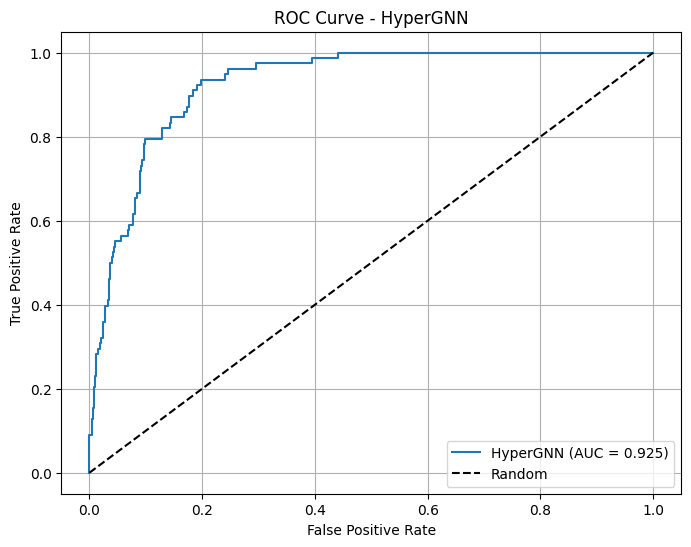


HYPERGNN ANALYSIS RESULTS (ALL 7 ML SCORES + STRUCTURAL)

Hypergraph Information:
  Number of hyperedges: 36
  Number of nodes: 34
  Average hyperedge size: 2.86

Machine Learning Scores:
  F1 Score: 0.4302
  Recall: 0.9872
  Precision: 0.2750
  Accuracy: 0.6364
  ROC-AUC: 0.9253
  Log Loss: 0.7125
  Matthews Correlation Coefficient: 0.3923

Structural Evaluation Scores:
  Avg. Internal Connectivity (Predicted): 0.6829
  Avg. Internal Connectivity (Random Baseline): 0.0877
  Connectivity Ratio (Predicted/Random): 7.79
  Avg. Node Degree (Overall): 3.03
  Avg. Node Degree (In Predictions): 3.70



In [10]:
karate_clique_hg = {
    'clique_0': {0, 1, 2, 3, 13},
    'clique_1': {0, 1, 2, 3, 7},
    'clique_2': {8, 30, 32, 33},
    'clique_3': {23, 29, 32, 33},
    'clique_4': {0, 1, 17},
    'clique_5': {0, 1, 19},
    'clique_6': {0, 1, 21},
    'clique_7': {0, 4, 10},
    'clique_8': {0, 4, 6},
    'clique_9': {0, 5, 10},
    'clique_10': {0, 5, 6},
    'clique_11': {0, 2, 8},
    'clique_12': {0, 3, 12},
    'clique_13': {2, 8, 32},
    'clique_14': {5, 6, 16},
    'clique_15': {14, 32, 33},
    'clique_16': {15, 32, 33},
    'clique_17': {18, 32, 33},
    'clique_18': {20, 32, 33},
    'clique_19': {22, 32, 33},
    'clique_20': {31, 32, 33},
    'clique_21': {26, 29, 33},
    'clique_22': {23, 27, 33},
    'clique_23': {28, 31, 33},
    'clique_24': {24, 25, 31},
    'clique_25': {0, 11},
    'clique_26': {0, 31},
    'clique_27': {1, 30},
    'clique_28': {2, 9},
    'clique_29': {2, 27},
    'clique_30': {2, 28},
    'clique_31': {9, 33},
    'clique_32': {13, 33},
    'clique_33': {19, 33},
    'clique_34': {24, 27},
    'clique_35': {23, 25}
}

print("\n\nExample 2: Karate Club Clique Hypergraph")
print(f"Number of nodes: {len(set.union(*karate_clique_hg.values()))}")
print(f"Number of hyperedges: {len(karate_clique_hg)}")

results_karate = full_hypergraph_analysis_complete(karate_clique_hg, num_predictions=100, plot_roc=True)
print_results_complete(results_karate)

### Example 3: Les Miserables Clique Hypergraph

Les Misérables (Knuth, 1993) hypergraph representation where nodes are characters and hyperedges correspond to cliques in the original character co-occurrence graph of Victor Hugo's novel.



Example 3: Les Miserables Clique Hypergraph
Number of nodes: 77
Number of hyperedges: 59
Starting HyperGNN analysis...
Converted hypergraph to incidence matrix: (77, 59)
Computed adjacency matrix for structural evaluation
Prepared node features: torch.Size([77, 77])
Training HyperGNN model...
Epoch 0, Loss: 0.0477
Epoch 20, Loss: 0.0246
Epoch 40, Loss: 0.0187
Generated node embeddings: torch.Size([77, 32])
Original hypergraph has 59 hyperedges
Hyperedge sizes: [10, 10, 8, 8, 7, 7, 7, 7, 7, 6, 6, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Generating 100 hyperedge predictions using embeddings...
Generated 100 predictions
Preparing data for ML evaluation...
Created 2926 samples for evaluation
Positive samples: 254, Negative samples: 2672
Computing structural evaluation metrics...

=== HyperGNN ANALYSIS RESULTS ===
precision: 0.1700
recall: 0.9764
f1: 0.2896
accuracy: 0.5841
matthews_corr

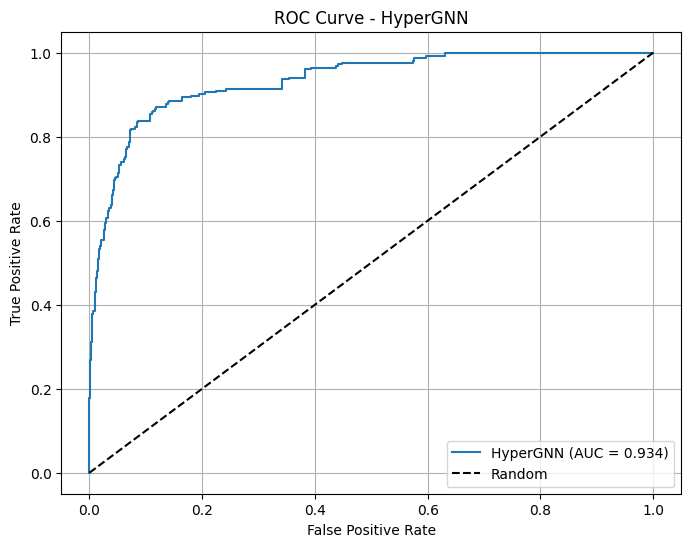


HYPERGNN ANALYSIS RESULTS (ALL 7 ML SCORES + STRUCTURAL)

Hypergraph Information:
  Number of hyperedges: 59
  Number of nodes: 77
  Average hyperedge size: 3.83

Machine Learning Scores:
  F1 Score: 0.2896
  Recall: 0.9764
  Precision: 0.1700
  Accuracy: 0.5841
  ROC-AUC: 0.9341
  Log Loss: 0.7374
  Matthews Correlation Coefficient: 0.2946

Structural Evaluation Scores:
  Avg. Internal Connectivity (Predicted): 0.3404
  Avg. Internal Connectivity (Random Baseline): 0.0371
  Connectivity Ratio (Predicted/Random): 9.18
  Avg. Node Degree (Overall): 2.94
  Avg. Node Degree (In Predictions): 2.94



In [11]:
lesmiserables_clique_hg = {
    'clique_0': {'Bahorel', 'Bossuet', 'Combeferre', 'Courfeyrac', 'Enjolras', 'Feuilly', 'Gavroche', 'Joly', 'Mabeuf', 'Marius'}, 
    'clique_1': {'Bahorel', 'Bossuet', 'Combeferre', 'Courfeyrac', 'Enjolras', 'Feuilly', 'Gavroche', 'Grantaire', 'Joly', 'Prouvaire'}, 
    'clique_2': {'Blacheville', 'Dahlia', 'Fameuil', 'Fantine', 'Favourite', 'Listolier', 'Tholomyes', 'Zephine'}, 
    'clique_3': {'Bahorel', 'Bossuet', 'Courfeyrac', 'Enjolras', 'Gavroche', 'Grantaire', 'Joly', 'MmeHucheloup'}, 
    'clique_4': {'Bamatabois', 'Brevet', 'Champmathieu', 'Chenildieu', 'Cochepaille', 'Judge', 'Valjean'}, 
    'clique_5': {'Babet', 'Claquesous', 'Gueulemer', 'Javert', 'MmeThenardier', 'Thenardier', 'Valjean'}, 
    'clique_6': {'Babet', 'Claquesous', 'Gueulemer', 'Javert', 'Montparnasse', 'Thenardier', 'Valjean'}, 
    'clique_7': {'Babet', 'Gavroche', 'Gueulemer', 'Javert', 'Montparnasse', 'Thenardier', 'Valjean'}, 
    'clique_8': {'Babet', 'Brujon', 'Claquesous', 'Eponine', 'Gueulemer', 'Montparnasse', 'Thenardier'}, 
    'clique_9': {'Babet', 'Brujon', 'Gavroche', 'Gueulemer', 'Montparnasse', 'Thenardier'}, 
    'clique_10': {'Babet', 'Claquesous', 'Eponine', 'Gueulemer', 'MmeThenardier', 'Thenardier'}, 
    'clique_11': {'Cosette', 'Gillenormand', 'LtGillenormand', 'Marius', 'MlleGillenormand'}, 
    'clique_12': {'Cosette', 'Gillenormand', 'Marius', 'MlleGillenormand', 'Valjean'}, 
    'clique_13': {'Bossuet', 'Enjolras', 'Gavroche', 'Marius', 'Valjean'}, 
    'clique_14': {'Cosette', 'Javert', 'MmeThenardier', 'Thenardier', 'Valjean'}, 
    'clique_15': {'Fantine', 'Javert', 'MmeThenardier', 'Thenardier', 'Valjean'}, 
    'clique_16': {'Courfeyrac', 'Eponine', 'Mabeuf', 'Marius'}, 
    'clique_17': {'Cosette', 'Marius', 'Thenardier', 'Valjean'}, 
    'clique_18': {'Gavroche', 'Marius', 'Thenardier', 'Valjean'}, 
    'clique_19': {'MlleBaptistine', 'MmeMagloire', 'Myriel', 'Valjean'}, 
    'clique_20': {'Cosette', 'Javert', 'Valjean', 'Woman2'}, 
    'clique_21': {'Claquesous', 'Enjolras', 'Javert', 'Valjean'}, 
    'clique_22': {'Enjolras', 'Gavroche', 'Javert', 'Valjean'}, 
    'clique_23': {'Bamatabois', 'Fantine', 'Javert', 'Valjean'}, 
    'clique_24': {'Fantine', 'Javert', 'Simplice', 'Valjean'}, 
    'clique_25': {'Cosette', 'Javert', 'Toussaint', 'Valjean'}, 
    'clique_26': {'Anzelma', 'Eponine', 'MmeThenardier', 'Thenardier'}, 
    'clique_27': {'Fantine', 'Perpetue', 'Simplice'}, 
    'clique_28': {'Child1', 'Child2', 'Gavroche'}, 
    'clique_29': {'Cosette', 'Marius', 'Tholomyes'}, 
    'clique_30': {'Fauchelevent', 'MotherInnocent', 'Valjean'}, 
    'clique_31': {'Fantine', 'Marguerite', 'Valjean'}, 
    'clique_32': {'Javert', 'Valjean', 'Woman1'}, 
    'clique_33': {'Fauchelevent', 'Javert', 'Valjean'}, 
    'clique_34': {'Eponine', 'Marius', 'Thenardier'}, 
    'clique_35': {'Marius', 'Pontmercy', 'Thenardier'}, 
    'clique_36': {'BaronessT', 'Gillenormand', 'Marius'}, 
    'clique_37': {'Gavroche', 'MmeBurgon'}, 
    'clique_38': {'Jondrette', 'MmeBurgon'}, 
    'clique_39': {'Mabeuf', 'MotherPlutarch'}, 
    'clique_40': {'Fauchelevent', 'Gribier'}, 
    'clique_41': {'Count', 'Myriel'}, 
    'clique_42': {'Cravatte', 'Myriel'}, 
    'clique_43': {'Gervais', 'Valjean'}, 
    'clique_44': {'Labarre', 'Valjean'}, 
    'clique_45': {'MmeDeR', 'Valjean'}, 
    'clique_46': {'Scaufflaire', 'Valjean'}, 
    'clique_47': {'Isabeau', 'Valjean'}, 
    'clique_48': {'MmePontmercy', 'Pontmercy'}, 
    'clique_49': {'MlleGillenormand', 'MmePontmercy'}, 
    'clique_50': {'MlleGillenormand', 'MlleVaubois'}, 
    'clique_51': {'Myriel', 'OldMan'}, 
    'clique_52': {'Geborand', 'Myriel'}, 
    'clique_53': {'CountessDeLo', 'Myriel'}, 
    'clique_54': {'Champtercier', 'Myriel'}, 
    'clique_55': {'Magnon', 'MmeThenardier'}, 
    'clique_56': {'Gillenormand', 'Magnon'}, 
    'clique_57': {'Boulatruelle', 'Thenardier'}, 
    'clique_58': {'Myriel', 'Napoleon'}
}

print("\n\nExample 3: Les Miserables Clique Hypergraph")
print(f"Number of nodes: {len(set.union(*lesmiserables_clique_hg.values()))}")
print(f"Number of hyperedges: {len(lesmiserables_clique_hg)}")

results_lesmiserables = full_hypergraph_analysis_complete(lesmiserables_clique_hg, num_predictions=100, plot_roc=True)
print_results_complete(results_lesmiserables)

### Example 4: Randomly Generated Hypergraph



Example 3: Random Hypergraph
Number of nodes: 50
Number of hyperedges: 25
Starting HyperGNN analysis...
Converted hypergraph to incidence matrix: (47, 25)
Computed adjacency matrix for structural evaluation
Prepared node features: torch.Size([47, 47])
Training HyperGNN model...
Epoch 0, Loss: 0.4365
Epoch 20, Loss: 0.0120
Epoch 40, Loss: 0.0115
Generated node embeddings: torch.Size([47, 32])
Original hypergraph has 25 hyperedges
Hyperedge sizes: [4, 7, 8, 7, 6, 3, 6, 8, 4, 3, 3, 4, 3, 3, 7, 7, 5, 5, 8, 4, 7, 5, 5, 3, 7]
Generating 50 hyperedge predictions using embeddings...
Generated 50 predictions
Preparing data for ML evaluation...
Created 1081 samples for evaluation
Positive samples: 289, Negative samples: 792
Computing structural evaluation metrics...

=== HyperGNN ANALYSIS RESULTS ===
precision: 0.4611
recall: 0.8616
f1: 0.6007
accuracy: 0.6938
matthews_corrcoef: 0.4374
roc_auc: 0.8384
log_loss: 0.8793
avg_predicted_connectivity: 0.1764
avg_original_connectivity: 0.3267
avg_ran

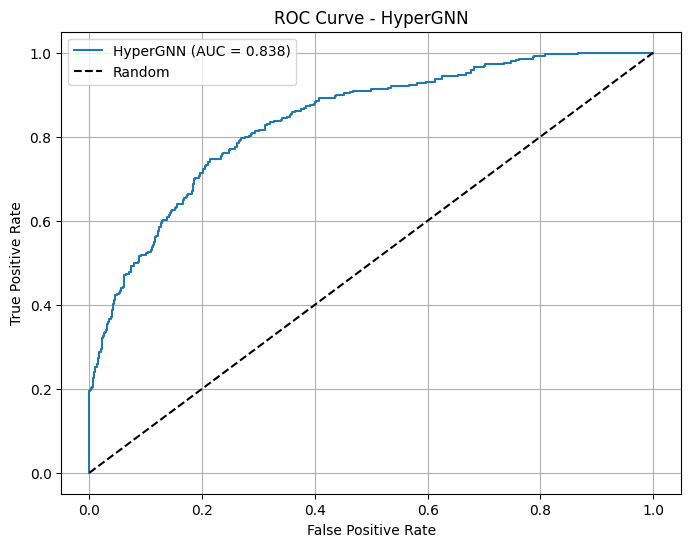


HYPERGNN ANALYSIS RESULTS (ALL 7 ML SCORES + STRUCTURAL)

Hypergraph Information:
  Number of hyperedges: 25
  Number of nodes: 47
  Average hyperedge size: 5.28

Machine Learning Scores:
  F1 Score: 0.6007
  Recall: 0.8616
  Precision: 0.4611
  Accuracy: 0.6938
  ROC-AUC: 0.8384
  Log Loss: 0.8793
  Matthews Correlation Coefficient: 0.4374

Structural Evaluation Scores:
  Avg. Internal Connectivity (Predicted): 0.1764
  Avg. Internal Connectivity (Random Baseline): 0.0613
  Connectivity Ratio (Predicted/Random): 2.88
  Avg. Node Degree (Overall): 2.81
  Avg. Node Degree (In Predictions): 3.06



In [12]:
# Generate a random hypergraph
vertices_random = list(range(1, 51))  # 50 nodes
hyperedge_names_random = [f'rand_he_{i}' for i in range(1, 31)] # 30 hyperedges

random_hg = hypergraph_random_creator(
    vertices=vertices_random,
    hyperedge_names=hyperedge_names_random,
    m=25,  # Create 25 hyperedges
    minv=3,  # Min 3 nodes per hyperedge
    maxv=8,  # Max 8 nodes per hyperedge
    weighted=False
)

print("\n\nExample 3: Random Hypergraph")
print(f"Number of nodes: {len(vertices_random)}")
print(f"Number of hyperedges: {len(random_hg)}")

results_random = full_hypergraph_analysis_complete(random_hg, num_predictions=50, plot_roc=True)
print_results_complete(results_random)

## Comparison Tables

In [14]:
def create_complete_comparison_table_with_save(results_list, example_names, 
                                               method_name, task_name, 
                                               save_dir="results", 
                                               display_results=True):
 
    comparison_data = []
    
    for i, results in enumerate(results_list):
        hg_info = results['hypergraph_info']
        ml_scores = results['ml_scores']
        eval_scores = results['structural_evaluation']
        
        row = {
            'Hypergraph': example_names[i],
            'Nodes': hg_info['num_nodes'],
            'Hyperedges': hg_info['num_hyperedges'],
            'Avg HE Size': round(hg_info['avg_hyperedge_size'], 2),
            # The 7 ML Scores
            'F1 Score': round(ml_scores['f1'], 4),
            'Recall': round(ml_scores['recall'], 4),
            'Precision': round(ml_scores['precision'], 4),
            'Accuracy': round(ml_scores['accuracy'], 4),
            'ROC-AUC': round(ml_scores['roc_auc'], 4),
            'Log Loss': round(ml_scores['log_loss'], 4) if ml_scores['log_loss'] != float('inf') else 'inf',
            'Matthews Coeff': round(ml_scores['matthews_corrcoef'], 4),
            # Structural Scores
            'Predicted Connectivity': round(eval_scores['avg_predicted_internal_connectivity'], 4),
            'Random Connectivity': round(eval_scores['avg_random_baseline_connectivity'], 4),
            'Connectivity Ratio': round(eval_scores['connectivity_ratio'], 2),
            'Avg Node Degree (Overall)': round(eval_scores['avg_overall_node_degree'], 2),
            'Avg Node Degree (Predicted)': round(eval_scores['avg_node_degree_in_predictions'], 2)
        }
        comparison_data.append(row)
    
    # Create DataFrame
    df = pd.DataFrame(comparison_data)
    
    # Save results for aggregation
    save_results_for_aggregation(df, method_name, task_name, save_dir)
    
    # Display results if requested (original functionality)
    if display_results:
        display_comparison_tables(df)
    
    return df

def save_results_for_aggregation(df, method_name, task_name, save_dir):
    """
    Save the comparison results in a structured format for later aggregation.
    """
    # Create directory structure
    method_dir = Path(save_dir) / method_name
    method_dir.mkdir(parents=True, exist_ok=True)
    
    # Prepare data for saving
    save_data = {
        'metadata': {
            'method': method_name,
            'task': task_name,
            'timestamp': datetime.now().isoformat(),
            'num_hypergraphs': len(df)
        },
        'results': df.to_dict('records')
    }
    
    # Save to JSON file
    filename = f"{task_name}_results.json"
    filepath = method_dir / filename
    
    with open(filepath, 'w') as f:
        json.dump(save_data, f, indent=2, default=str)
    
    print(f"✓ Results saved to: {filepath}")

def display_comparison_tables(df):
    """
    Display the comparison tables in the original format.
    """
    # Set pandas display options for better formatting
    pd.set_option('display.max_columns', None)
    pd.set_option('display.precision', 4)

    # 1. ML SCORES COMPARISON TABLE (FIRST)
    print("\n" + "="*90)
    print("ML SCORES COMPARISON TABLE")
    print("="*90)
    ml_columns = ['Hypergraph', 'F1 Score', 'Recall', 'Precision', 'Accuracy', 'ROC-AUC', 'Log Loss', 'Matthews Coeff']
    ml_df = df[ml_columns]

    # Format ML table nicely
    print(f"{'Hypergraph':<20} {'F1':<8} {'Recall':<8} {'Precision':<10} {'Accuracy':<9} {'ROC-AUC':<8} {'Log Loss':<9} {'Matthews':<9}")
    print("-" * 90)
    for i, row in ml_df.iterrows():
        # Handle potential string values (like 'inf')
        log_loss_str = f"{row['Log Loss']:.4f}" if isinstance(row['Log Loss'], (int, float)) else str(row['Log Loss'])
        print(f"{row['Hypergraph']:<20} {row['F1 Score']:<8.4f} {row['Recall']:<8.4f} {row['Precision']:<10.4f} {row['Accuracy']:<9.4f} {row['ROC-AUC']:<8.4f} {log_loss_str:<9} {row['Matthews Coeff']:<9.4f}")
    print("="*90)

    # 2. STRUCTURAL SCORES COMPARISON TABLE
    print("\n\n" + "="*100)
    print("STRUCTURAL SCORES COMPARISON TABLE")
    print("="*100)

    structural_columns = ['Hypergraph', 'Nodes', 'Hyperedges', 'Avg HE Size', 'Predicted Connectivity', 
                         'Random Connectivity', 'Connectivity Ratio']
    structural_df = df[structural_columns]

    # Format structural table nicely
    print(f"{'Hypergraph':<20} {'Nodes':<6} {'HEdges':<7} {'Avg Size':<9} {'Pred Conn':<10} {'Rand Conn':<10} {'Conn Ratio':<10}")
    print("-" * 100)
    for i, row in structural_df.iterrows():
        print(f"{row['Hypergraph']:<20} {row['Nodes']:<6} {row['Hyperedges']:<7} {row['Avg HE Size']:<9.2f} {row['Predicted Connectivity']:<10.4f} {row['Random Connectivity']:<10.4f} {row['Connectivity Ratio']:<10.2f}")
    print("="*100)

    # 3. COMPLETE COMPARISON TABLE (SIMPLIFIED)
    print("\n\n" + "="*80)
    print("COMPLETE COMPARISON TABLE - SUMMARY")
    print("="*80)
    print("(Showing key metrics only for readability)")
    print("-"*80)
    summary_columns = ['Hypergraph', 'Nodes', 'Hyperedges', 'F1 Score', 'ROC-AUC', 'Connectivity Ratio']
    summary_df = df[summary_columns]
    print(f"{'Hypergraph':<20} {'Nodes':<6} {'HEdges':<8} {'F1':<8} {'ROC-AUC':<8} {'Conn Ratio':<11}")
    print("-" * 80)
    for i, row in summary_df.iterrows():
        print(f"{row['Hypergraph']:<20} {row['Nodes']:<6} {row['Hyperedges']:<8} {row['F1 Score']:<8.4f} {row['ROC-AUC']:<8.4f} {row['Connectivity Ratio']:<11.2f}")
    print("="*80)

example_names = ['Southern Women', 'Karate Club', 'Les Miserables', 'Random Hypergraph']
results_list = [results_sw, results_karate, results_lesmiserables, results_random]

comparison_df = create_complete_comparison_table_with_save(
    results_list=results_list,
    example_names=example_names,
    method_name='HyperGNN',
    task_name='hypergraph_reconstruction',
    save_dir='results',
    display_results=True
)    

✓ Results saved to: results/HyperGNN/hypergraph_reconstruction_results.json

ML SCORES COMPARISON TABLE
Hypergraph           F1       Recall   Precision  Accuracy  ROC-AUC  Log Loss  Matthews 
------------------------------------------------------------------------------------------
Southern Women       0.7590   0.6116   1.0000     0.6928    1.0000   0.4548    0.4977   
Karate Club          0.4302   0.9872   0.2750     0.6364    0.9253   0.7125    0.3923   
Les Miserables       0.2896   0.9764   0.1700     0.5841    0.9341   0.7374    0.2946   
Random Hypergraph    0.6007   0.8616   0.4611     0.6938    0.8384   0.8793    0.4374   


STRUCTURAL SCORES COMPARISON TABLE
Hypergraph           Nodes  HEdges  Avg Size  Pred Conn  Rand Conn  Conn Ratio
----------------------------------------------------------------------------------------------------
Southern Women       18     14      9.29      0.6619     0.4243     1.56      
Karate Club          34     36      2.86      0.6829     0.0877 